In [1]:
# train.py

import os
import torch
import numpy as np
import warnings
import pickle
warnings.filterwarnings(action='ignore')

from data_loader import load_data_1m
from feature_calculations_2 import (
    resample_data, calculate_MA_data, calculate_ema_bollinger_bands, calculate_rsi,
    calculate_macd, calculate_stochastic_oscillator, calculate_adx, calculate_atr,
    calculate_obv, calculate_williams_r, base_feature_fn, cyclic_encode_fn, calculate_support_resistance_numba
)
from strategies import BB_fitness_fn, BB_MACD_fitness_fn
from dataset import make_dataset, replace_nan_with_zero
from train_functions_inference_bi_2 import inference, fitness_fn, generation_valid, generation_test

from Prescriptor import Prescriptor, CryptoModelTCN
from Evolution.crossover import UniformCrossover, WeightedSumCrossover, DifferentialEvolutionOperator, CenDE_DOBLOperator, SkipCrossover
from Evolution.mutation import MultiplyNormalMutation, MultiplyUniformMutation, AddNormalMutation, AddUniformMutation, ChainMutation, FlipSignMutation
from Evolution.mutation import RandomValueMutation
from Evolution.selection import RouletteSelection, TournamentSelection, ParetoLexsortSelection
from Evolution import Evolution

In [2]:
# Load Data
data_1m = load_data_1m('/root/daily/bit/data/1min_bitusdt_test.pkl')
# data_1m = data_1m.iloc[-200000:].reset_index(drop=True)
# data_1m = data_1m.iloc[3200000:].reset_index(drop=True)

In [3]:
# data_1m = data_1m.iloc[2000000:2700000].reset_index(drop=True)

In [4]:

data_1d = resample_data(data_1m, '1D')
data_1d['Close time'] = data_1d.index
data_1d = data_1d.reset_index(drop=True)

# Apply Feature Calculations
# For 1D Data
data_1d, ma_cols_1d, ma_cols_rel_1d = calculate_MA_data(data_1d, 60, 'EMA', '_1d')
data_1d, bb_cols_1d, bb_cols_rel_1d = calculate_ema_bollinger_bands(data_1d, 60, extra_str='_1d')
data_1d, rsi_cols_1d = calculate_rsi(data_1d, window=20, extra_str='_1d')
data_1d, macd_cols_1d = calculate_macd(data_1d, 20, 120, 60, extra_str='_1d')
data_1d, stoch_cols_1d = calculate_stochastic_oscillator(data_1d, 60, 20, extra_str='_1d')
data_1d, adx_cols_1d = calculate_adx(data_1d, 60, extra_str='_1d')
data_1d, atr_cols_1d = calculate_atr(data_1d, 60, extra_str='_1d')
data_1d, obv_cols_1d = calculate_obv(data_1d, extra_str='_1d')
data_1d, will_cols_1d = calculate_williams_r(data_1d, 60, extra_str='_1d')
data_1d, sr_col_1d = calculate_support_resistance_numba(data_1d, window=60, extra_str='_1d')
data_1d, base_feature_1d = base_feature_fn(data_1d, extra_str='_1d', alpha=10)
data_1d, cyclice_encoding_1d = cyclic_encode_fn(data_1d, 'Close time', 'day_of_week')

# For 1M Data
data_1m, ma_cols, ma_cols_rel = calculate_MA_data(data_1m, 240, 'EMA')
data_1m, bb_cols, bb_cols_rel = calculate_ema_bollinger_bands(data_1m, 240)
data_1m, macd_cols = calculate_macd(data_1m, 60, 600, 240)
data_1m, rsi_cols = calculate_rsi(data_1m, window=60)
data_1m, stoch_cols = calculate_stochastic_oscillator(data_1m, 240, 60)
data_1m, adx_cols = calculate_adx(data_1m, 240)
data_1m, atr_cols = calculate_atr(data_1m, 240)
data_1m, obv_cols = calculate_obv(data_1m)
data_1m, will_cols = calculate_williams_r(data_1m, 240)
data_1m, sr_col = calculate_support_resistance_numba(data_1m, window=240)
data_1m, base_feature = base_feature_fn(data_1m, alpha=100)
data_1m, cyclice_encoding = cyclic_encode_fn(data_1m, 'Open time')

data_1m, short_ma_cols, short_ma_cols_rel = calculate_MA_data(data_1m, 60, 'EMA')
data_1m, long_ma_cols, long_ma_cols_rel = calculate_MA_data(data_1m, 180, 'EMA')

data_1m, short_ma_cols, short_ma_cols_rel = calculate_MA_data(data_1m, 20, 'EMA')
data_1m, long_ma_cols, long_ma_cols_rel = calculate_MA_data(data_1m, 60, 'EMA')
data_1m, _, _ = calculate_ema_bollinger_bands(data_1m, 60)

# Prepare Feature Columns
drop_column = [
    'Open time', 'Close time', 'Quote asset volume', 'Ignore',
    'Number of trades', 'Taker buy base asset volume', 'Taker buy quote asset volume'
]

test_column = ['Quote asset volume', 'Number of trades', 'Taker buy base asset volume',
               'Taker buy quote asset volume']
# feature_column = (
#     test_column + cyclice_encoding + ma_cols_rel + bb_cols_rel + rsi_cols + macd_cols + stoch_cols +
#     adx_cols + will_cols + sr_col + base_feature  # Excluding obv and atr
# )

feature_column = (
    test_column + cyclice_encoding +  base_feature  # Excluding obv and atr
)
feature_column_1d = (
    test_column + cyclice_encoding_1d + ma_cols_rel_1d + bb_cols_rel_1d + rsi_cols_1d + macd_cols_1d + stoch_cols_1d +
    adx_cols_1d + will_cols_1d + sr_col_1d + base_feature_1d
)


# bb_entry_pos_list, patience_list, bb_entry_index_list = BB_fitness_fn(data_1m)
bb_macd_entry_pos_list, patience_list, bb_macd_entry_index_list = BB_MACD_fitness_fn(data_1m, 240, 60, 180)
# bb_macd_entry_pos_list, patience_list, bb_macd_entry_index_list = simple_fitness_fn(data_1m, 240, 60, 180)
# bb_macd_entry_pos_list, patience_list, bb_macd_entry_index_list = BB_MACD_fitness_fn(data_1m, 60, 20, 60)

# Prepare Dataset
data_tensor = make_dataset(
    data_1m, data_1d,
    using_column=feature_column, using_column_1d=feature_column_1d,
    window_size=240, window_size_1d=60,
    entry_pos_list=bb_macd_entry_pos_list, patience_list=patience_list,
    use_1d_data=True
)
entry_pos_list = np.array(bb_macd_entry_pos_list)[np.array(bb_macd_entry_pos_list) != 'hold']

dataset_1m = []
dataset_1d = []
skip_data_cnt = 0
for data in data_tensor:
    if len(data[0]) == 240 and len(data[1]) == 60:
        dataset_1m.append(torch.from_numpy(data[0]).unsqueeze(dim=0))
        dataset_1d.append(torch.from_numpy(data[1]).unsqueeze(dim=0))
    else:
        skip_data_cnt += 1
dataset_1m = torch.cat(dataset_1m, dim=0)
dataset_1d = torch.cat(dataset_1d, dim=0)

# Avoid division by zero by replacing zero denominators with a small epsilon value
epsilon = 1e-10
dataset_1m[:, :, :4] = dataset_1m[:, :, :4] / (torch.mean(dataset_1m[:, :, :4], dim=1).unsqueeze(dim=1) + epsilon)
dataset_1d[:, :, :4] = dataset_1d[:, :, :4] / (torch.mean(dataset_1d[:, :, :4], dim=1).unsqueeze(dim=1) + epsilon)

dataset_1m = replace_nan_with_zero(dataset_1m)
dataset_1d = replace_nan_with_zero(dataset_1d)


100%|██████████| 3761060/3761060 [07:05<00:00, 8842.28it/s] 


In [5]:
torch.set_grad_enabled(False)
torch.backends.cudnn.benchmark = True

state_dict_path = '/root/daily/bit_4/generation/generation_13.pt'
if os.path.exists(state_dict_path):
    state_dict = torch.load(state_dict_path)
    start_gen = state_dict['generation'] + 1
    best_profit = state_dict['best_profit']
    best_chromosomes = state_dict['best_chromosomes']

# best_index = [i for i in range(len(best_profit))]
# with open('/root/daily/bit/all_intersect_solution_index.pkl', 'rb') as f:
#     best_index = pickle.load(f)

best_index = [i for i in range(len(best_profit))]
# best_index = [ 3,  7,  8,  9, 11, 21, 24, 30, 31, 34, 37, 39, 41] 

# Evolution Setup
device = 'cuda:1'
group = len(best_index)
prescriptor = Prescriptor(
    basic_block=CryptoModelTCN, 
    small_input_dim=14, 
    large_input_dim=25,
    fc_hidden_size=24,
    small_lstm_hidden_dim=24,
    large_lstm_hidden_dim=24,
    output_dim=16, 
    after_input_dim=19, 
    after_hidden_dim=8, 
    after_output_dim=5, 
    num_blocks=group,
).to(device).eval()

total_param = sum(p.numel() for p in prescriptor.parameters())
print(f"Total parameters: {total_param}")

selection = RouletteSelection(elite_num=2000, parents_num=4000, minimize=False)
# selection = ParetoLexsortSelection(elite_num=2000, parents_num=4000,
#                                     priority=[], prior_ratio= [],
#                                     prob_method= 'softmax',minimize=False)
crossover = DifferentialEvolutionOperator()
mutation = RandomValueMutation(mut_prob=0.05)
evolution = Evolution(
    prescriptor=prescriptor,
    selection=selection,
    crossover=crossover,
    mutation=mutation
)

# start_gen = 0
# best_profit = None
# best_chromosomes = None


#     prescriptor.load_state_dict(state_dict['prescriptor_state_dict'],strict=True)

# # start_gen = 0

# # # best_profit = None
# # # best_chromosomes = None

best_chromosomes = best_chromosomes[best_index]
init_chromosomes, base_ch_shape, after_ch_shape, device = evolution.flatten_chromosomes()
device = 'cuda:0'
evolution.update_chromosomes(best_chromosomes, base_ch_shape, after_ch_shape, device)

Total parameters: 819144


In [6]:
valid_skip_data_cnt = int(len(dataset_1m)*0.6) + skip_data_cnt
test_skip_data_cnt = int(len(dataset_1m)*0.8) + skip_data_cnt

In [7]:
chromosomes_size=len(best_index)
window_size=240
gen_loop=100
best_size=len(best_index)
elite_size=len(best_index)
profit_init=1


In [8]:
total_profit, tracking_info = generation_test(
    data_1m=data_1m,
    dataset_1m=dataset_1m,
    dataset_1d=dataset_1d,
    prescriptor=prescriptor,
    start_data_cnt=skip_data_cnt,
    skip_data_cnt=skip_data_cnt,
    # end_data_cnt=valid_skip_data_cnt,
    end_data_cnt=len(dataset_1m)-2+skip_data_cnt,
    chromosomes_size=chromosomes_size,
    window_size=window_size,
    profit_init=profit_init,
    entry_index_list=bb_macd_entry_index_list,
    entry_pos_list=entry_pos_list,
    device=device,
)

100%|█████████▉| 45020/45022 [05:00<00:00, 149.98it/s]


In [9]:
now_profit_shape = np.vstack(tracking_info['now_profit'])
profit_shape = np.vstack(tracking_info['profit'])
pos_list_shape = np.vstack(tracking_info['pos_list'])
leverage_shape = np.vstack(tracking_info['leverage_ratio'])
enter_ratio_shape = np.vstack(tracking_info['enter_ratio'])
price_shape = np.vstack(tracking_info['price_list'])
additional_count_shape = np.vstack(tracking_info['additional_count'])
cumulative_returns_shape = np.vstack(tracking_info['cumulative_returns'])

Text(0, 0.5, 'Price')

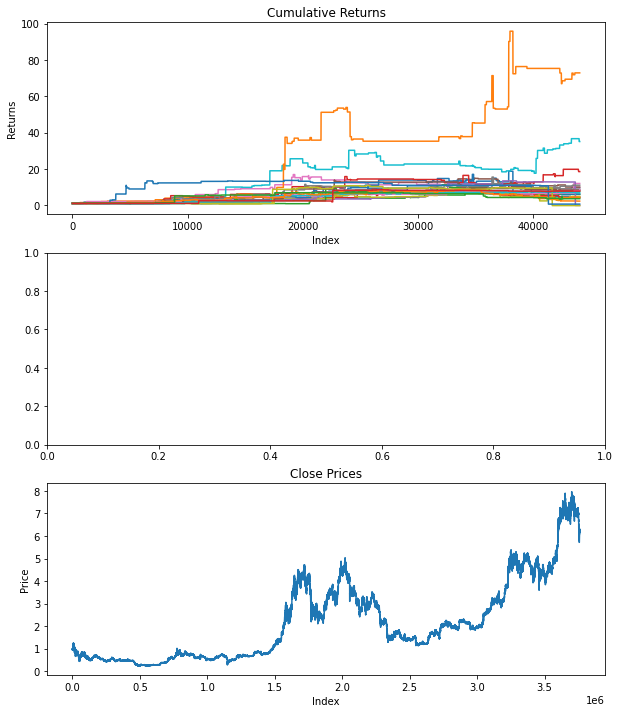

In [10]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 1, figsize=(10, 12))

# Plot cumulative returns
axs[0].plot(cumulative_returns_shape)
axs[0].set_title('Cumulative Returns')
axs[0].set_xlabel('Index')
axs[0].set_ylabel('Returns')

# # Plot leverage
# axs[1].plot(leverage_shape[:, 55])
# axs[1].set_title('Leverage')
# axs[1].set_xlabel('Index')
# axs[1].set_ylabel('Leverage Ratio')

# Plot data_1m['Close']
axs[2].plot(data_1m['Close']/data_1m['Close'].iloc[0])
axs[2].set_title('Close Prices')
axs[2].set_xlabel('Index')
axs[2].set_ylabel('Price')


In [ ]:
train_profit = generation_test(
    data_1m=data_1m,
    dataset_1m=dataset_1m,
    dataset_1d=dataset_1d,
    prescriptor=prescriptor,
    start_data_cnt=skip_data_cnt,
    skip_data_cnt=skip_data_cnt,
    end_data_cnt=valid_skip_data_cnt,
    # end_data_cnt=len(dataset_1m)-2+skip_data_cnt,
    chromosomes_size=chromosomes_size,
    window_size=window_size,
    profit_init=profit_init,
    entry_index_list=bb_macd_entry_index_list,
    entry_pos_list=entry_pos_list,
    device=device
)

In [ ]:
valid_profit = generation_test(
    data_1m=data_1m,
    dataset_1m=dataset_1m,
    dataset_1d=dataset_1d,
    prescriptor=prescriptor,
    start_data_cnt=valid_skip_data_cnt,
    skip_data_cnt=skip_data_cnt,
    end_data_cnt=test_skip_data_cnt,
    # end_data_cnt=len(dataset_1m)-2+skip_data_cnt,
    chromosomes_size=chromosomes_size,
    window_size=window_size,
    profit_init=profit_init,
    entry_index_list=bb_macd_entry_index_list,
    entry_pos_list=entry_pos_list,
    device=device
)

In [ ]:
best_profit[best_index][:, 4]

In [ ]:
valid_profit[0][:, 6]

In [ ]:
test_profit = generation_test(
    data_1m=data_1m,
    dataset_1m=dataset_1m,
    dataset_1d=dataset_1d,
    prescriptor=prescriptor,
    start_data_cnt=test_skip_data_cnt,
    skip_data_cnt=skip_data_cnt,
    # end_data_cnt=valid_skip_data_cnt,
    end_data_cnt=len(dataset_1m)-2+skip_data_cnt,
    chromosomes_size=chromosomes_size,
    window_size=window_size,
    profit_init=profit_init,
    entry_index_list=bb_macd_entry_index_list,
    entry_pos_list=entry_pos_list,
    device=device
)

In [ ]:
valid_test_profit = generation_test(
    data_1m=data_1m,
    dataset_1m=dataset_1m,
    dataset_1d=dataset_1d,
    prescriptor=prescriptor,
    start_data_cnt=valid_skip_data_cnt,
    skip_data_cnt=skip_data_cnt,
    # end_data_cnt=valid_skip_data_cnt,
    end_data_cnt=len(dataset_1m)-2+skip_data_cnt,
    chromosomes_size=chromosomes_size,
    window_size=window_size,
    profit_init=profit_init,
    entry_index_list=bb_macd_entry_index_list,
    entry_pos_list=entry_pos_list,
    device=device
)

In [14]:
valid_index = np.where(valid_profit[:, 6] > 1.5)[0]
test_index = np.where(test_profit[:, 6] > 1.5)[0]

In [16]:
train_solution_index = np.where((train_profit[:, 0] > .5) & (train_profit[:, 6] > 2.) & (train_profit[:, 5] < 60) & (train_profit[:, 4] > 0.7))[0]
valid_solution_index = np.where((valid_profit[:, 0] > .5) & (valid_profit[:, 6] > 2.) & (valid_profit[:, 5] < 60) & (valid_profit[:, 4] > 0.7))[0]
total_solution_index = np.where((total_profit[:, 0] > .5) & (total_profit[:, 6] > 2.) & (total_profit[:, 5] < 60) & (total_profit[:, 4] > 0.7))[0]
valid_test_solution_index = np.where((valid_test_profit[:, 0] > .5) & (valid_test_profit[:, 6] > 2.) & (valid_test_profit[:, 5] < 60) & (valid_test_profit[:, 4] > 0.7))[0]
test_solution_index = np.where((test_profit[:, 0] > .5) & (test_profit[:, 6] > 2.) & (test_profit[:, 5] < 60) & (test_profit[:, 4] > 0.7))[0]

# Calculate the intersection of all solution indices
all_intersect_solution_index = np.intersect1d(
    np.intersect1d(train_solution_index, valid_solution_index),
    np.intersect1d(total_solution_index, 
                   np.intersect1d(valid_test_solution_index, test_solution_index))
)

In [ ]:
test_profit

In [ ]:
valid_skip_data_cnt

In [ ]:
bb_macd_entry_index_list[valid_skip_data_cnt]

In [ ]:
data_1m.iloc[:bb_macd_entry_index_list[valid_skip_data_cnt]]

In [ ]:
data_1m.iloc[bb_macd_entry_index_list[valid_skip_data_cnt]:bb_macd_entry_index_list[test_skip_data_cnt]]

In [ ]:
data_1m.iloc[bb_macd_entry_index_list[test_skip_data_cnt]:]